In [1]:
import torch
import torchvision
from torch import nn
import matplotlib.pyplot as plt
from torch.utils.data import DataLoader
import torchvision.transforms as transforms
import numpy as np

c:\Users\Shlomi\AppData\Local\Programs\Python\Python310\lib\site-packages\tqdm\auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
BATCH_SIZE = 256

# Transform

In [3]:
mean = torch.tensor([0.485, 0.456, 0.406])
std = torch.tensor([0.229, 0.224, 0.225])

transform = transforms.Compose([
	transforms.Resize((224, 224)),  # Works on both PIL and tensor
	transforms.ToTensor(),
	transforms.Normalize(mean, std)  # Works only on tensors, therefor we need to convert the image to tensor beforehand
]) 

In [4]:
dataset = torchvision.datasets.CIFAR10(root="./cifar10", train=False, download=True, transform=transform)
dataloader = torch.utils.data.DataLoader(dataset, batch_size=BATCH_SIZE, shuffle=False, num_workers=2)

print(dataset)

Files already downloaded and verified
Dataset CIFAR10
    Number of datapoints: 10000
    Root location: ./cifar10
    Split: Test
    StandardTransform
Transform: Compose(
               Resize(size=(224, 224), interpolation=bilinear, max_size=None, antialias=None)
               ToTensor()
               Normalize(mean=tensor([0.4850, 0.4560, 0.4060]), std=tensor([0.2290, 0.2240, 0.2250]))
           )


In [5]:
def plot_9_imgs(batch, labels):
	n = 3
	offset = 0  # We can start showing images at some offset untill (offset + n*n)

	fig, ax = plt.subplots(n, n)
	fig.tight_layout()

	for row in range(n):
		for col in range(n):
			cur_ax = ax[row, col]
			img_i = row*n + col + offset

			cur_ax.set_axis_off()
			cur_ax.set_title(str(img_i) + ": " + str(dataset.classes[labels[img_i]]))
			o = batch[img_i].numpy().transpose(1, 2, 0)
			cur_ax.imshow(o)

# ResNet18 - load and change last layer

In [6]:
resnet18 = torchvision.models.resnet18(pretrained=True)
resnet18.eval()

dataloader_iter = iter(dataloader)
images_batch, labels_batch = dataloader_iter.next()

print("Last layer, before change:", resnet18.fc)  # Out features = 1000

resnet18.fc = nn.Linear(in_features=512, out_features=10)

print("Last layer, after change:", resnet18.fc)  # Notice 3x224x224

print("Image shape after transforms:", images_batch[0].shape) # Notice 3x224x224 after the transformation

Last layer, before change: Linear(in_features=512, out_features=1000, bias=True)
Last layer, after change: Linear(in_features=512, out_features=10, bias=True)
Image shape after transforms: torch.Size([3, 224, 224])


# See how ResNet deals with CIFAR10 images BEFORE TRAINING

In [7]:
prediction = resnet18(images_batch)
softmax = nn.Softmax(dim=1)
labels_prediction = torch.max(softmax(prediction), dim=1)

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping i

Text(0.5, 0.98, 'Ground truth')

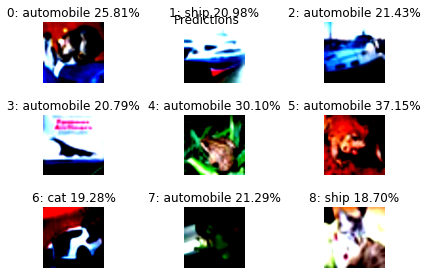

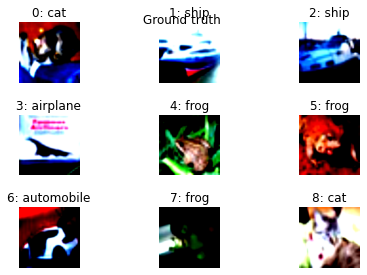

In [8]:
n = 3
fig, ax = plt.subplots(n, n)
fig.tight_layout()

for row in range(n):
	for col in range(n):
		cur_ax = ax[row, col]
		img_i = row*n + col

		label = dataset.classes[labels_prediction.indices[img_i]]

		prob = labels_prediction.values[img_i].item() * 100 # Get probability of the image being of the class
		prob = '%.2f' % prob # Show only 2 decimal places

		title = f"{img_i}: {label} {prob}%"

		cur_ax.set_axis_off()
		cur_ax.set_title(str(title))
		o = images_batch[img_i].numpy().transpose(1, 2, 0)
		cur_ax.imshow(o)

plt.suptitle("Predictions")


plot_9_imgs(images_batch, labels_batch)
plt.suptitle("Ground truth")

# GPU

In [9]:
if torch.cuda.is_available():
    device = torch.device('cuda:0')
else:
    device = torch.device('cpu')

print("Using GPU?", torch.cuda.is_available(), device)

torch.cuda.empty_cache()  # I had errors with CUDA taking much of the GPU memory :O

resnet18.to(device);  # If you using CPU, remove this line
# Note to self: Put ';' at the end of the line to disable output print

Using GPU? True cuda:0


# Disable gradients

In [10]:
"""
PyTorch documentation:
https://pytorch.org/docs/stable/notes/autograd.html#setting-requires-grad

Setting requires_grad should be the main way you control which parts of the model are part of the gradient computation, for example, if you need to freeze parts of your pretrained model during model fine-tuning.
To freeze parts of your model, simply apply .requires_grad_(False) to the parameters that you don’t want updated. And as described above, since computations that use these parameters as inputs would not be recorded in the forward pass, they won’t have their .grad fields updated in the backward pass because they won’t be part of the backward graph in the first place, as desired.
"""

# Disable training/learning for the model entirely by setting requires_grad to False
for param in resnet18.parameters():
	param.requires_grad = False

# Only enable the last layer for training by setting requires_grad to True
for param in resnet18.fc.parameters():
	param.requires_grad = True

print("First layer grad: ", next(resnet18.parameters()).requires_grad) # First layer
print("Last layer grad: ", next(resnet18.fc.parameters()).requires_grad) # Last layer

First layer grad:  False
Last layer grad:  True


# Training time!